In [1]:
nome = 'mateus oliveira'
print(f'Meu nome é {nome}')

Meu nome é mateus oliveira


#  Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural simples para prever a proxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Língua".

Este dataset já possui um tamanho razoável e é bem provável que você vai precisar rodar seus experimentos com GPU.

Alguns conselhos úteis:
- **ATENÇÃO:** o dataset é bem grande. Não dê comando de imprimí-lo.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

In [2]:
# iremos utilizar a biblioteca dos transformers para ter acesso ao tokenizador do BERT.
!pip install transformers

     |████████████████████████████████| 4.2 MB 34.5 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 6.6 MB 66.1 MB/s 
     |████████████████████████████████| 596 kB 60.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Importação dos pacotes

In [3]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook


In [4]:
# Check which GPU we are using
!nvidia-smi

Mon May 16 12:45:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


## Implementação do MyDataset

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

from typing import List

def tokenize_timbau(text: str):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids


class MyDataset():
    def __init__(self, texts: List[str], tokenizer, context_size: int):
        self.texts = texts
        self.tokenizer = tokenizer
        self.context_size = context_size
        self.vocab = list(dict.fromkeys(" ".join(self.texts).split(' ')))# organize code
        self.embbeddings = torch.FloatTensor(len(self.vocab),self.context_size)
        self.count = 0
        self.tam = 0
        
        self.x = []
        self.y = []

        for idx, sentence in enumerate(self.texts):
            sentence_tokens = tokenize_timbau(sentence)
        
            for i, _ in enumerate(sentence_tokens):
                if i + context_size >= len(sentence_tokens):
                    break

                self.x.append(sentence_tokens[i:i+context_size])
                self.y.append(sentence_tokens[i+context_size])
        
        self.x, self.y = torch.LongTensor(self.x), torch.LongTensor(self.y)
        
        self.tam = self.x.shape[0]

    def __len__(self):
        return self.tam

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [7]:
tokenize_timbau('pizza')

[13779, 15616]

## Teste se sua implementação do MyDataset está correta

In [8]:

dummy_texts = ['Eu gosto de correr', 'Ela gosta muito de comer pizza']

dummy_dataset = MyDataset(texts=dummy_texts, tokenizer=tokenizer, context_size=3)
dummy_loader = DataLoader(dummy_dataset, batch_size=6, shuffle=False)
assert len(dummy_dataset) == 5
print('passou no assert de tamanho do dataset')

first_batch_input, first_batch_target = next(iter(dummy_loader))

print(first_batch_input)

correct_first_batch_input = torch.LongTensor(
    [[ 3396, 10303,   125],
     [ 1660,  5971,   785],
     [ 5971,   785,   125],
     [  785,   125,  1847],
     [  125,  1847, 13779]])

correct_first_batch_target = torch.LongTensor([13239,   125,  1847, 13779, 15616])

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert de input')
assert torch.equal(first_batch_target, correct_first_batch_target)
print('Passou no assert de target')

passou no assert de tamanho do dataset
tensor([[ 3396, 10303,   125],
        [ 1660,  5971,   785],
        [ 5971,   785,   125],
        [  785,   125,  1847],
        [  125,  1847, 13779]])
Passou no assert de input
Passou no assert de target


In [9]:
tokenize_timbau('Ela gosta muito de comer pizza')

[1660, 5971, 785, 125, 1847, 13779, 15616]

In [10]:
dummy_dataset[1],dummy_dataset[0]

((tensor([1660, 5971,  785]), tensor(125)),
 (tensor([ 3396, 10303,   125]), tensor(13239)))

# Carregamento do dataset 

Iremos usar uma pequena amostra do dataset [BrWaC](https://www.inf.ufrgs.br/pln/wiki/index.php?title=BrWaC) para treinar e avaliar nosso modelo de linguagem.

In [11]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt

--2022-05-16 12:45:20--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula7/sample_brwac.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123983611 (118M) [text/plain]
Saving to: ‘sample_brwac.txt’

sample_brwac.txt    100%[===================>] 118.24M  70.7MB/s    in 1.7s    

2022-05-16 12:45:22 (70.7 MB/s) - ‘sample_brwac.txt’ saved [123983611/123983611]



In [12]:
# Load datasets
context_size = 9

valid_examples = 100
test_examples = 100
texts = open('sample_brwac.txt').readlines()

print('Truncating for debugging purposes.')
texts = texts[:500]  

training_texts = texts[:-(valid_examples + test_examples)]
valid_texts = texts[-(valid_examples + test_examples):-test_examples]
test_texts = texts[-test_examples:]

training_dataset = MyDataset(texts=training_texts, tokenizer=tokenizer, context_size=context_size)
valid_dataset = MyDataset(texts=valid_texts, tokenizer=tokenizer, context_size=context_size)
test_dataset = MyDataset(texts=test_texts, tokenizer=tokenizer, context_size=context_size)

Truncating for debugging purposes.


In [13]:
texts[:8]

['Linkbar Há alguns anos, o número de rapazes e moças que subiam ao púlpito para pregar era maior que o de hoje. Na sua simplicidade, falavam do amor de Deus, da Salvação e davam testemunho sob a unção do Espirito Santo. Hoje, parece que a figura do "preletor oficial" inibiu muitos de falarem com ousadia a Palavra de Deus. Parece que há um receio de falar diante de um público que, certamente, é mais intelectualizado que há alguns anos. Jovens pregadores ficam embaraçados e cometem certos deslizes, que poderiam ser evitados. Neste modesto trabalho, vamos dar apenas algumas sugestões, e não um estudo sobre a Homilética (Arte de Falar em Publico). I -O QUE PREGAR? É a comunicação verbal da Palavra de Deus aos ouvintes. É a transmissão do evangelho de Nosso Senhor Jesus Cristo às pessoas que precisam ouvi-lo. II- QUAL A FINALIDADE DA PREGAÇÃO? É persuadir as pessoas a aceitarem a mensagem da Palavra de Deus para sua salvação (descrentes) ou para seu crescimento espiritual (crentes). Diante

In [14]:
print(f'training examples: {len(training_dataset)}')
print(f'valid examples: {len(valid_dataset)}')
print(f'test examples: {len(test_dataset)}')

training examples: 406905
valid examples: 135562
test examples: 136690


In [31]:
import torch.nn.functional as F

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, context_size, embedding_dim, hidden_size):
        """
        Implements the Neural Language Model proposed by Bengio et al."

        Args:
            vocab_size (int): Size of the input vocabulary.
            context_size (int): Size of the sequence to consider as context for prediction.
            embedding_dim (int): Dimension of the embedding layer for each word in the context.
            hidden_size (int): Size of the hidden layer.
        """
        super(LanguageModel, self).__init__()

        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size, bias = False)
        #print(context_size * embedding_dim, hidden_size,vocab_size)

    def forward(self, inputs):
        """
        Args:
            inputs is a LongTensor of shape (batch_size, context_size)
        """
        # compute x': concatenation of x1 and x2 embeddings
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # compute h: tanh(W_1.x' + b)
        out = torch.tanh(self.linear1(embeds))
        # compute W_2.h
        out = self.linear2(out)
        # compute y: log_softmax(W_2.h)
        log_probs = F.log_softmax(out, dim=1)
        # return log probabilities
        # BATCH_SIZE x len(vocab)
        return log_probs

## Teste o modelo com um exemplo

In [32]:
model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=512,
    hidden_size=5240,
).to(device)

sample_train, _ = next(iter(DataLoader(training_dataset)))
sample_train_gpu = sample_train.to(device)
model(sample_train_gpu).shape

torch.Size([1, 29794])

In [33]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

Number of model parameters: 195526248


## Assert da Perplexidade


In [34]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)


def perplexity(logits, target):
    """
    Computes the perplexity.

    Args:
        logits: a FloatTensor of shape (batch_size, vocab_size)
        target: a LongTensor of shape (batch_size,)

    Returns:
        A float corresponding to the perplexity.
    """
    loss = F.cross_entropy(logits, target)
    return torch.exp(loss)


n_examples = 1000

sample_train, target_token_ids = next(iter(DataLoader(training_dataset, batch_size=n_examples)))
sample_train_gpu = sample_train.to(device)
target_token_ids = target_token_ids.to(device)
logits = model(sample_train_gpu)

my_perplexity = perplexity(logits=logits, target=target_token_ids)

print(f'my perplexity:              {int(my_perplexity)}')
print(f'correct initial perplexity: {tokenizer.vocab_size}')

assert math.isclose(my_perplexity, tokenizer.vocab_size, abs_tol=2000)
print('Passou o no assert da perplexidade')

my perplexity:              31692
correct initial perplexity: 29794
Passou o no assert da perplexidade


In [35]:
class SaveBestModel:

    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"Best validation loss: {self.best_valid_loss}")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')

In [36]:
!mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


## Laço de Treinamento e Validação

In [37]:
max_examples = 100_000_000
eval_every_steps = 5000
lr = 3e-5


model = LanguageModel(
    vocab_size=tokenizer.vocab_size,
    context_size=context_size,
    embedding_dim=128,
    hidden_size=256,
).to(device)

save_best_model = SaveBestModel()

train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=64)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def train_step(input, target):
    model.train()
    model.zero_grad()

    logits = model(input.to(device))
    loss = nn.functional.cross_entropy(logits, target.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

last_loss = 30986.66 #Length vocab size adjust
patience = 2
trigger_times = 0


def validation_step(input, target):
    logits = model(input)
    loss = nn.functional.cross_entropy(logits, target)
    return loss.item()


train_losses = []
n_examples = 0
step = 0

train_loss = []
valid_loss = []


while n_examples < max_examples:
    for input, target in train_loader:
        loss = train_step(input.to(device), target.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_ppl = np.exp(np.average(train_losses))

            with torch.no_grad():
                valid_ppl = np.exp(np.average([
                    validation_step(input.to(device), target.to(device))
                    for input, target in validation_loader]))

            print(f'{step} steps; {n_examples} examples so far; train ppl: {train_ppl:.2f}, valid ppl: {valid_ppl:.2f}')
            train_losses = []

        current_loss = valid_ppl

        train_loss.append(train_ppl)
        valid_loss.append(valid_ppl)

#----------------------Early stopping------------------------------------
        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break

        else:
            trigger_times = 0

        last_loss = current_loss

        save_best_model(
        last_loss, 0, model, optimizer, nn.functional.cross_entropy
        )
#------------------------------------------------------------------------        


        n_examples += len(input)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

0 steps; 0 examples so far; train ppl: 32004.73, valid ppl: 30986.66
Trigger Times: 1
Best validation loss: 30986.66214553628
5000 steps; 320000 examples so far; train ppl: 4087.57, valid ppl: 2301.27
Best validation loss: 2301.265342033807
10000 steps; 640000 examples so far; train ppl: 1570.82, valid ppl: 1817.15
Best validation loss: 1817.147579183615
15000 steps; 960000 examples so far; train ppl: 1242.17, valid ppl: 1616.11
Best validation loss: 1616.105924197009
20000 steps; 1280000 examples so far; train ppl: 1065.53, valid ppl: 1494.26
Best validation loss: 1494.2595853014168
25000 steps; 1600000 examples so far; train ppl: 930.79, valid ppl: 1403.61
Best validation loss: 1403.6058474599579
30000 steps; 1920000 examples so far; train ppl: 822.99, valid ppl: 1333.60
Best validation loss: 1333.5961450956797
35000 steps; 2240000 examples so far; train ppl: 744.32, valid ppl: 1275.92
Best validation loss: 1275.9195671904417
40000 steps; 2560000 examples so far; train ppl: 676.80, v

KeyboardInterrupt: ignored

## Avaliação final no dataset de teste


Bonus: o modelo com menor perplexidade no dataset de testes ganhará 0.5 ponto na nota final.

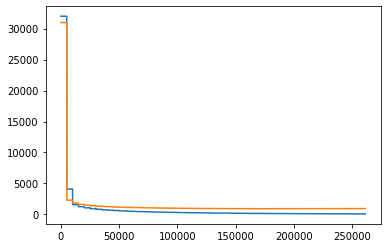

In [39]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(valid_loss)

#plot

In [40]:
test_loader = DataLoader(test_dataset, batch_size=64)

with torch.no_grad():
    test_ppl = np.exp(np.average([
        validation_step(input.to(device), target.to(device))
        for input, target in test_loader
    ]))

print(f'test perplexity: {test_ppl}')

test perplexity: 1008.314158289614


## Teste seu modelo com uma sentença

Escolha uma sentença gerada pelo modelo que ache interessante.

In [44]:
def tokenize(text: str, tokenizer):
    return tokenizer(text, return_tensors=None, add_special_tokens=False).input_ids

In [45]:
prompt = 'Eu gosto de comer pizza pois me faz'
max_output_tokens = 10

for _ in range(max_output_tokens):
    input_ids = tokenize(text=prompt, tokenizer=tokenizer)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(torch.LongTensor(input_ids_truncated).to(device))
    # Ao usarmos o argmax, a saída do modelo em cada passo é token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

Eu gosto de comer pizza pois me faz parte
Eu gosto de comer pizza pois me faz parte da
Eu gosto de comer pizza pois me faz parte da doença
Eu gosto de comer pizza pois me faz parte da doença.
Eu gosto de comer pizza pois me faz parte da doença. O
Eu gosto de comer pizza pois me faz parte da doença. O primeiro
Eu gosto de comer pizza pois me faz parte da doença. O primeiro caso
Eu gosto de comer pizza pois me faz parte da doença. O primeiro caso de
Eu gosto de comer pizza pois me faz parte da doença. O primeiro caso de explosivos
Eu gosto de comer pizza pois me faz parte da doença. O primeiro caso de explosivos e


In [ ]:
tokeni